In [2]:
!pip -q install scikit-image imbalanced-learn torch torchvision torchaudio --upgrade

import os, time
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Skimage features
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern, canny

# Torch (for future deep features, optional)
import torch
from torchvision import models, transforms

# ML & metrics
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             cohen_kappa_score, balanced_accuracy_score)
from sklearn.model_selection import train_test_split

In [6]:
DATA_ROOT = "isic-2019-skin-disease/final"   # adjust if needed
train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "val")

# Discover classes
classes = sorted([d.name for d in os.scandir(train_dir) if d.is_dir()])
num_classes = len(classes)
class_to_idx = {c:i for i,c in enumerate(classes)}

print("Classes:", classes)

Classes: ['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']


In [8]:
IMG_SIZE = (128, 128)

def load_image_gray(path, size=IMG_SIZE):
    img = Image.open(path).convert("RGB")
    img = img.resize(size, Image.BILINEAR)
    img = np.array(img) / 255.0
    return rgb2gray(img)

def get_image_paths_labels(root_dir):
    paths, labels = [], []
    for cls in classes:
        for p in glob(os.path.join(root_dir, cls, "*")):
            if p.lower().endswith((".jpg", ".jpeg", ".png")):
                paths.append(p)
                labels.append(class_to_idx[cls])
    return paths, np.array(labels, dtype=int)

Xtr_paths, ytr = get_image_paths_labels(train_dir)
Xval_paths, yval = get_image_paths_labels(val_dir)
print(len(Xtr_paths), "train images |", len(Xval_paths), "val images")

17728 train images | 2529 val images


In [10]:
IMG_SIZE = (128, 128)

def load_image_gray(path, size=IMG_SIZE):
    img = Image.open(path).convert("RGB")
    img = img.resize(size, Image.BILINEAR)
    img = np.array(img) / 255.0
    return rgb2gray(img)

def get_image_paths_labels(root_dir):
    paths, labels = [], []
    for cls in classes:
        for p in glob(os.path.join(root_dir, cls, "*")):
            if p.lower().endswith((".jpg", ".jpeg", ".png")):
                paths.append(p)
                labels.append(class_to_idx[cls])
    return paths, np.array(labels, dtype=int)

Xtr_paths, ytr = get_image_paths_labels(train_dir)
Xval_paths, yval = get_image_paths_labels(val_dir)
print(len(Xtr_paths), "train images |", len(Xval_paths), "val images")

17728 train images | 2529 val images


In [12]:
def fe_hog(gray):
    return hog(gray, orientations=9, pixels_per_cell=(8,8),
               cells_per_block=(2,2), block_norm='L2-Hys',
               transform_sqrt=True, feature_vector=True)

def fe_lbp(gray, P=8, R=1):
    lbp = local_binary_pattern(gray, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=P+2, range=(0, P+2), density=True)
    return hist.astype(np.float32)

def fe_edges(gray):
    edges = canny(gray, sigma=1.0)
    ed = edges.mean()
    small = resize(edges.astype(float), (64,64), anti_aliasing=False).ravel()
    return np.concatenate([[ed], small]).astype(np.float32)
def extract_batch(paths, extractor):
    feats = []
    for p in paths:
        g = load_image_gray(p)
        feats.append(extractor(g))
    return np.vstack(feats)

In [14]:
Xhog_tr, Xhog_val = extract_batch(Xtr_paths, fe_hog), extract_batch(Xval_paths, fe_hog)
Xlbp_tr, Xlbp_val = extract_batch(Xtr_paths, fe_lbp), extract_batch(Xval_paths, fe_lbp)
Xedg_tr, Xedg_val = extract_batch(Xtr_paths, fe_edges), extract_batch(Xval_paths, fe_edges)

print("HOG:", Xhog_tr.shape, "LBP:", Xlbp_tr.shape, "EDGE:", Xedg_tr.shape)



C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


HOG: (17728, 8100) LBP: (17728, 10) EDGE: (17728, 4097)


In [16]:
RNG = 42
CLFS = {
    "LR": LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DT": DecisionTreeClassifier(class_weight="balanced", random_state=RNG),
    "RF": RandomForestClassifier(n_estimators=300, class_weight="balanced_subsample",
                                 n_jobs=-1, random_state=RNG)
}

def eval_suite(y_true, y_pred, y_proba=None, n_classes=None):
    out = {
        "acc": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "prec_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro"),
        "bal_acc": balanced_accuracy_score(y_true, y_pred),
        "kappa": cohen_kappa_score(y_true, y_pred),
    }
    if y_proba is not None:
        Y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
        try:
            out["roc_auc_macro"] = roc_auc_score(Y_true_bin, y_proba, average="macro", multi_class="ovr")
        except:
            out["roc_auc_macro"] = np.nan
    return out

def fit_eval_one(clf_name, Xtr, ytr, Xval, yval, scale=True):
    steps = []
    if scale:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", CLFS[clf_name]))
    pipe = Pipeline(steps).fit(Xtr, ytr)

    y_pred = pipe.predict(Xval)
    y_proba = pipe.predict_proba(Xval) if hasattr(pipe.named_steps["clf"], "predict_proba") else None
    return eval_suite(yval, y_pred, y_proba, n_classes=num_classes), pipe

In [18]:
RESULTS = []
for name, (Xtr_, Xval_) in {"HOG": (Xhog_tr, Xhog_val),
                            "LBP": (Xlbp_tr, Xlbp_val),
                            "EDGE": (Xedg_tr, Xedg_val)}.items():
    for clf in CLFS.keys():
        metrics, pipe = fit_eval_one(clf, Xtr_, ytr, Xval_, yval)
        RESULTS.append({"features": name, "clf": clf, **metrics})

df_results = pd.DataFrame(RESULTS).sort_values(["features","f1_macro"], ascending=[True, False])
print(df_results)


C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


   features  clf       acc  f1_macro  prec_macro  recall_macro   bal_acc  \
10     EDGE   DT  0.355081  0.166491    0.165050      0.169945  0.169945   
8      EDGE   LR  0.308027  0.161086    0.164074      0.169626  0.169626   
9      EDGE  KNN  0.305654  0.113993    0.150416      0.134786  0.134786   
11     EDGE   RF  0.514037  0.105669    0.322315      0.135042  0.135042   
1       HOG  KNN  0.504943  0.219522    0.320126      0.232213  0.232213   
0       HOG   LR  0.430210  0.216844    0.213632      0.222207  0.222207   
2       HOG   DT  0.376433  0.161226    0.161055      0.161770  0.161770   
3       HOG   RF  0.551206  0.159642    0.314507      0.170442  0.170442   
5       LBP  KNN  0.503756  0.219455    0.268814      0.214250  0.214250   
7       LBP   RF  0.551997  0.214253    0.453523      0.205384  0.205384   
6       LBP   DT  0.416370  0.206234    0.205344      0.207474  0.207474   
4       LBP   LR  0.238039  0.145749    0.193589      0.229405  0.229405   

       kapp

In [20]:
# ================================
# 8. Robustness Check
# ================================
def perturb(gray, noise_std=0.05, rotate_deg=15):
    noisy = np.clip(gray + np.random.normal(0, noise_std, gray.shape), 0, 1)
    img = Image.fromarray((noisy*255).astype(np.uint8))
    img = img.rotate(rotate_deg, resample=Image.BILINEAR)
    return np.array(img)/255.0

def extract_with_perturb(paths, extractor, n=500):
    feats = []
    for p in paths[:n]:
        img = load_image_gray(p)
        img_pert = perturb(img)
        feats.append(extractor(img_pert))
    return np.vstack(feats)

Xhog_val_rob = extract_with_perturb(Xval_paths, fe_hog)
Xlbp_val_rob = extract_with_perturb(Xval_paths, fe_lbp)
Xedg_val_rob = extract_with_perturb(Xval_paths, fe_edges)
yval_subset = yval[:500]

ROBUST_RESULTS = []
for name, Xrob in [("HOG",Xhog_val_rob), ("LBP",Xlbp_val_rob), ("EDGE",Xedg_val_rob)]:
    Xtr_map, Xv_map = {"HOG": Xhog_tr, "LBP": Xlbp_tr, "EDGE": Xedg_tr}[name], \
                      {"HOG": Xhog_val,"LBP": Xlbp_val,"EDGE": Xedg_val}[name]

    for clf in CLFS.keys():
        m_clean, pipe = fit_eval_one(clf, Xtr_map, ytr, Xv_map, yval)
        yhat_rob = pipe.predict(Xrob)
        m_rob = eval_suite(yval_subset, yhat_rob, None, n_classes=num_classes)

        ROBUST_RESULTS.append({
            "features": name, "clf": clf,
            "clean_acc": m_clean["acc"], "clean_f1": m_clean["f1_macro"],
            "rob_acc": m_rob["acc"], "rob_f1": m_rob["f1_macro"],
            "drop_acc": m_clean["acc"] - m_rob["acc"],
            "drop_f1": m_clean["f1_macro"] - m_rob["f1_macro"]
        })

robust_df = pd.DataFrame(ROBUST_RESULTS)
print("\nRobustness Summary:\n", robust_df)

C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Rec


Robustness Summary:
    features  clf  clean_acc  clean_f1  rob_acc    rob_f1  drop_acc   drop_f1
0       HOG   LR   0.430210  0.216844    0.200  0.080294  0.230210  0.136550
1       HOG  KNN   0.504943  0.219522    0.134  0.092278  0.370943  0.127245
2       HOG   DT   0.376433  0.161226    0.284  0.114510  0.092433  0.046716
3       HOG   RF   0.551206  0.159642    0.058  0.030769  0.493206  0.128873
4       LBP   LR   0.238039  0.145749    0.000  0.000000  0.238039  0.145749
5       LBP  KNN   0.503756  0.219455    0.004  0.010870  0.499756  0.208586
6       LBP   DT   0.416370  0.206234    0.006  0.013515  0.410370  0.192719
7       LBP   RF   0.551997  0.214253    0.000  0.000000  0.551997  0.214253
8      EDGE   LR   0.308027  0.161086    0.126  0.054186  0.182027  0.106899
9      EDGE  KNN   0.305654  0.113993    0.160  0.065719  0.145654  0.048273
10     EDGE   DT   0.355081  0.166491    0.144  0.069705  0.211081  0.096786
11     EDGE   RF   0.514037  0.105669    0.000  0.0000

C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [22]:
best_perf_idx = df_results["f1_macro"].idxmax()
best_perf_row = df_results.loc[best_perf_idx]

# Best robustness (lowest F1 drop)
best_robust_idx = robust_df["drop_f1"].idxmin()
best_robust_row = robust_df.loc[best_robust_idx]

print("\n=== Best Predictive Performance Model ===")
print(best_perf_row.to_frame().T.to_string(index=False))

print("\n=== Best Robustness/Stability Model ===")
print(best_robust_row.to_frame().T.to_string(index=False))

# Choose final winner (example: prioritize robustness)
final_best_features = best_robust_row["features"]
final_best_clf = best_robust_row["clf"]

print(f"\nFinal Best Model → {final_best_clf} with {final_best_features}")


=== Best Predictive Performance Model ===
features clf       acc  f1_macro prec_macro recall_macro   bal_acc     kappa roc_auc_macro
     HOG KNN  0.504943  0.219522   0.320126     0.232213  0.232213  0.225309      0.649643

=== Best Robustness/Stability Model ===
features clf clean_acc  clean_f1 rob_acc   rob_f1  drop_acc   drop_f1
     HOG  DT  0.376433  0.161226   0.284  0.11451  0.092433  0.046716

Final Best Model → DT with HOG


In [24]:
# ================================
# 7. Select Best Model with Metrics
# ================================

# Best predictive performance (highest macro F1)
best_perf_idx = df_results["f1_macro"].idxmax()
best_perf_row = df_results.loc[best_perf_idx]

# Best robustness (lowest F1 drop)
best_robust_idx = robust_df["drop_f1"].idxmin()
best_robust_row = robust_df.loc[best_robust_idx]

print("\n=== Best model based on predictive performance ===")
print(best_perf_row)

print("\n=== Best model based on robustness/stability ===")
print(best_robust_row)

# Choose final winner (prioritizing robustness here)
final_best_features = best_robust_row["features"]
final_best_clf = best_robust_row["clf"]

print(f"\nFinal Best Model → {final_best_clf} with {final_best_features}")



=== Best model based on predictive performance ===
features              HOG
clf                   KNN
acc              0.504943
f1_macro         0.219522
prec_macro       0.320126
recall_macro     0.232213
bal_acc          0.232213
kappa            0.225309
roc_auc_macro    0.649643
Name: 1, dtype: object

=== Best model based on robustness/stability ===
features          HOG
clf                DT
clean_acc    0.376433
clean_f1     0.161226
rob_acc         0.284
rob_f1        0.11451
drop_acc     0.092433
drop_f1      0.046716
Name: 2, dtype: object

Final Best Model → DT with HOG


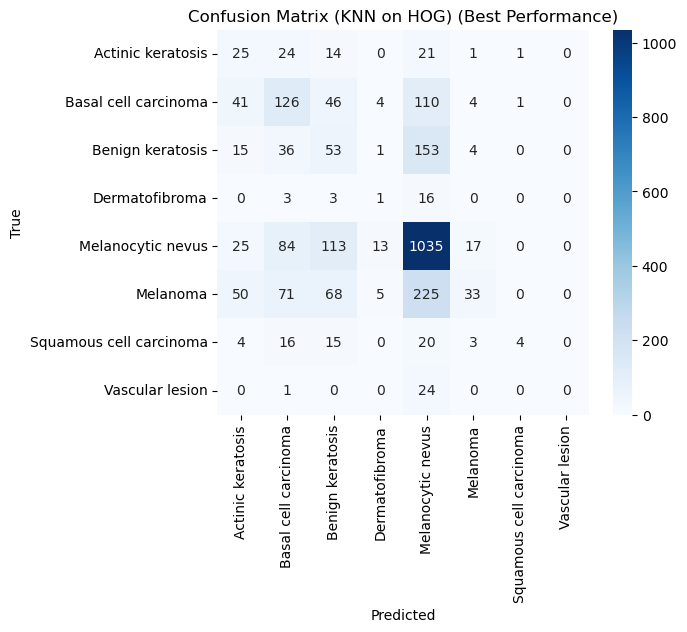


Classification Report (KNN on HOG) (Best Performance):

                         precision    recall  f1-score   support

      Actinic keratosis       0.16      0.29      0.20        86
   Basal cell carcinoma       0.35      0.38      0.36       332
       Benign keratosis       0.17      0.20      0.18       262
         Dermatofibroma       0.04      0.04      0.04        23
      Melanocytic nevus       0.65      0.80      0.72      1287
               Melanoma       0.53      0.07      0.13       452
Squamous cell carcinoma       0.67      0.06      0.12        62
        Vascular lesion       0.00      0.00      0.00        25

               accuracy                           0.50      2529
              macro avg       0.32      0.23      0.22      2529
           weighted avg       0.51      0.50      0.46      2529



C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

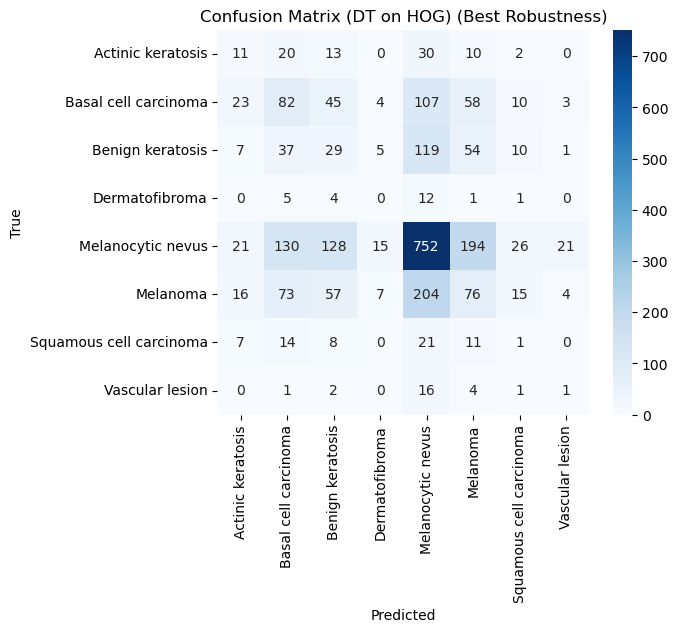


Classification Report (DT on HOG) (Best Robustness):

                         precision    recall  f1-score   support

      Actinic keratosis       0.13      0.13      0.13        86
   Basal cell carcinoma       0.23      0.25      0.24       332
       Benign keratosis       0.10      0.11      0.11       262
         Dermatofibroma       0.00      0.00      0.00        23
      Melanocytic nevus       0.60      0.58      0.59      1287
               Melanoma       0.19      0.17      0.18       452
Squamous cell carcinoma       0.02      0.02      0.02        62
        Vascular lesion       0.03      0.04      0.04        25

               accuracy                           0.38      2529
              macro avg       0.16      0.16      0.16      2529
           weighted avg       0.38      0.38      0.38      2529



In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_best_model(best_row, title_suffix=""):
    best_features, best_clf = best_row["features"], best_row["clf"]

    # Map features
    Xtr_map = {"HOG": Xhog_tr, "LBP": Xlbp_tr, "EDGE": Xedg_tr}[best_features]
    Xv_map  = {"HOG": Xhog_val,"LBP": Xlbp_val,"EDGE": Xedg_val}[best_features]

    # Train + predict
    _, best_pipe = fit_eval_one(best_clf, Xtr_map, ytr, Xv_map, yval)
    yhat_val = best_pipe.predict(Xv_map)

    # Confusion matrix
    cm = confusion_matrix(yval, yhat_val)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix ({best_clf} on {best_features}) {title_suffix}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification report
    print(f"\nClassification Report ({best_clf} on {best_features}) {title_suffix}:\n")
    print(classification_report(yval, yhat_val, target_names=classes))


# Evaluate both best models
evaluate_best_model(best_perf_row, title_suffix="(Best Performance)")
evaluate_best_model(best_robust_row, title_suffix="(Best Robustness)")

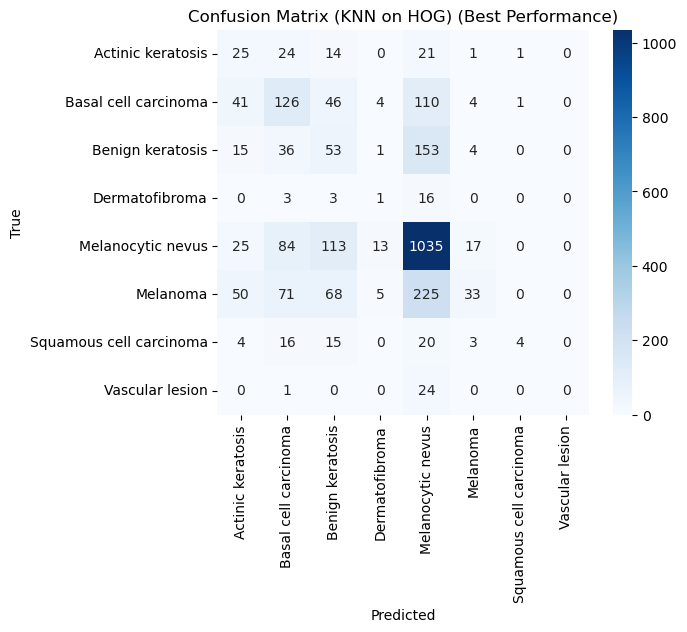


Classification Report (KNN on HOG) (Best Performance):

                         precision    recall  f1-score   support

      Actinic keratosis       0.16      0.29      0.20        86
   Basal cell carcinoma       0.35      0.38      0.36       332
       Benign keratosis       0.17      0.20      0.18       262
         Dermatofibroma       0.04      0.04      0.04        23
      Melanocytic nevus       0.65      0.80      0.72      1287
               Melanoma       0.53      0.07      0.13       452
Squamous cell carcinoma       0.67      0.06      0.12        62
        Vascular lesion       0.00      0.00      0.00        25

               accuracy                           0.50      2529
              macro avg       0.32      0.23      0.22      2529
           weighted avg       0.51      0.50      0.46      2529



C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\PRAVEEN VINODKUMAR\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result

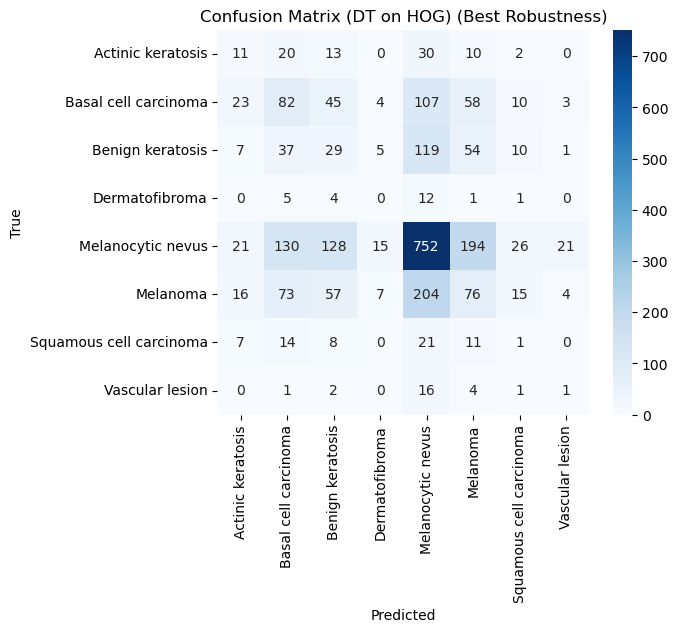


Classification Report (DT on HOG) (Best Robustness):

                         precision    recall  f1-score   support

      Actinic keratosis       0.13      0.13      0.13        86
   Basal cell carcinoma       0.23      0.25      0.24       332
       Benign keratosis       0.10      0.11      0.11       262
         Dermatofibroma       0.00      0.00      0.00        23
      Melanocytic nevus       0.60      0.58      0.59      1287
               Melanoma       0.19      0.17      0.18       452
Squamous cell carcinoma       0.02      0.02      0.02        62
        Vascular lesion       0.03      0.04      0.04        25

               accuracy                           0.38      2529
              macro avg       0.16      0.16      0.16      2529
           weighted avg       0.38      0.38      0.38      2529



In [30]:
# ================================
# 9. Confusion Matrix + Report
# ================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_confusion_and_report(best_row, title_suffix=""):
    best_features, best_clf = best_row["features"], best_row["clf"]

    # Map features
    Xtr_map = {"HOG": Xhog_tr, "LBP": Xlbp_tr, "EDGE": Xedg_tr}[best_features]
    Xv_map  = {"HOG": Xhog_val,"LBP": Xlbp_val,"EDGE": Xedg_val}[best_features]

    # Train + predict
    _, best_pipe = fit_eval_one(best_clf, Xtr_map, ytr, Xv_map, yval)
    yhat_val = best_pipe.predict(Xv_map)

    # Confusion Matrix
    cm = confusion_matrix(yval, yhat_val)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix ({best_clf} on {best_features}) {title_suffix}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Classification Report
    print(f"\nClassification Report ({best_clf} on {best_features}) {title_suffix}:\n")
    print(classification_report(yval, yhat_val, target_names=classes))

    # Return both pipe + validation features (needed for ROC)
    return best_pipe, Xv_map


# Run for both models → make sure to capture the outputs
pipe_perf, Xv_perf = evaluate_confusion_and_report(best_perf_row, "(Best Performance)")
pipe_robust, Xv_robust = evaluate_confusion_and_report(best_robust_row, "(Best Robustness)")


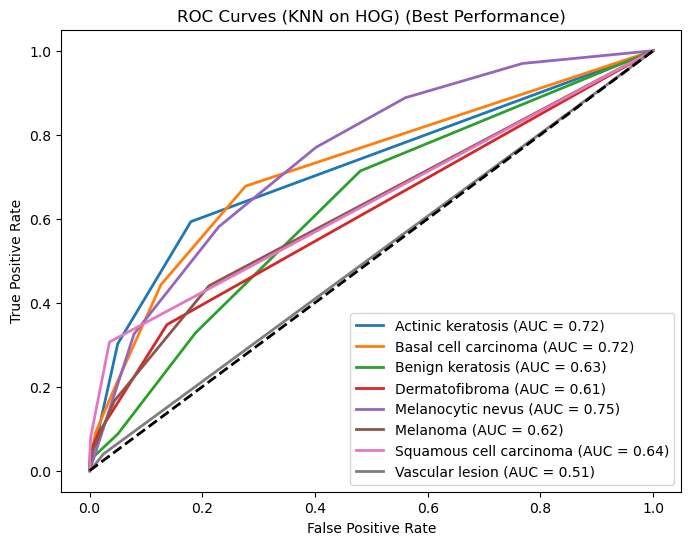

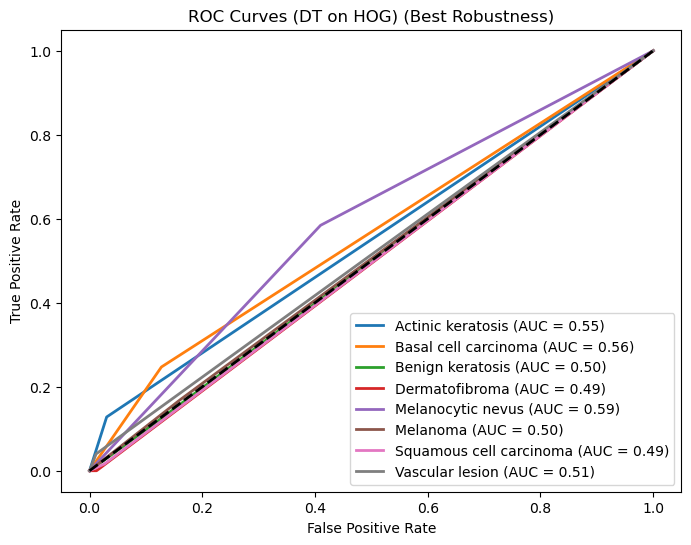

In [33]:
# ================================
# 10. ROC Curves
# ================================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curves(best_row, best_pipe, Xv_map, title_suffix=""):
    best_features, best_clf = best_row["features"], best_row["clf"]

    if not hasattr(best_pipe, "predict_proba"):
        print(f"{best_clf} on {best_features} does not support probability outputs → skipping ROC curves.")
        return

    # Probability scores
    y_proba = best_pipe.predict_proba(Xv_map)
    yval_bin = label_binarize(yval, classes=list(range(len(classes))))

    # Plot ROC per class
    plt.figure(figsize=(8,6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(yval_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{cls} (AUC = {roc_auc:.2f})")

    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.title(f"ROC Curves ({best_clf} on {best_features}) {title_suffix}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()


# Run ROC curves for both models
plot_roc_curves(best_perf_row, pipe_perf, Xv_perf, "(Best Performance)")
plot_roc_curves(best_robust_row, pipe_robust, Xv_robust, "(Best Robustness)")


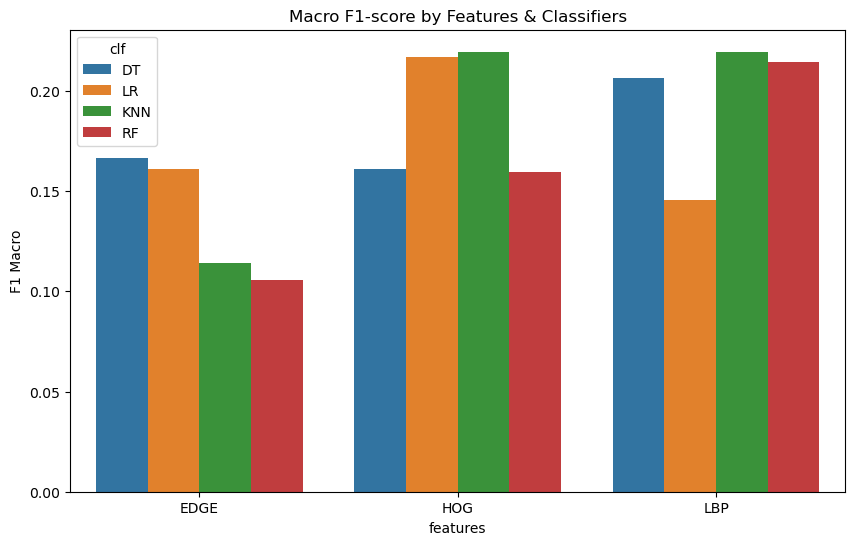

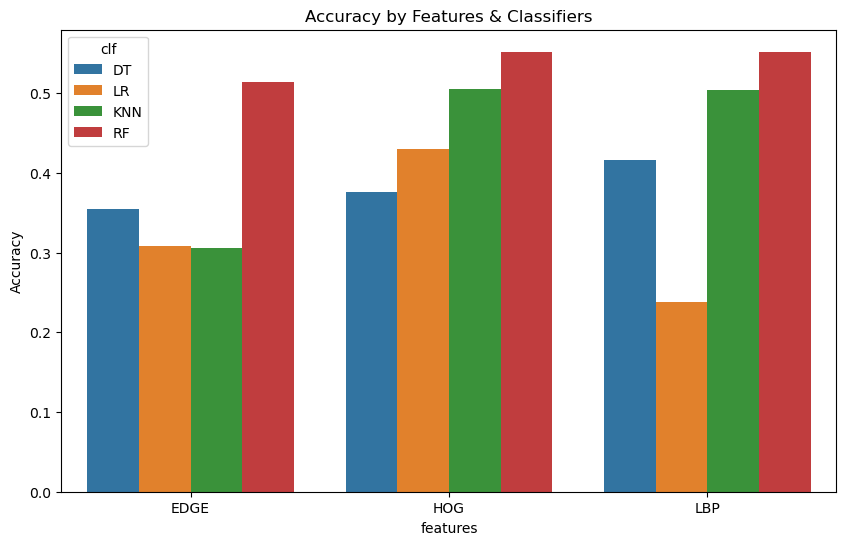

In [31]:
# Plot accuracy and f1_macro grouped by features
plt.figure(figsize=(10,6))
sns.barplot(data=df_results, x="features", y="f1_macro", hue="clf")
plt.title("Macro F1-score by Features & Classifiers")
plt.ylabel("F1 Macro")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=df_results, x="features", y="acc", hue="clf")
plt.title("Accuracy by Features & Classifiers")
plt.ylabel("Accuracy")
plt.show()


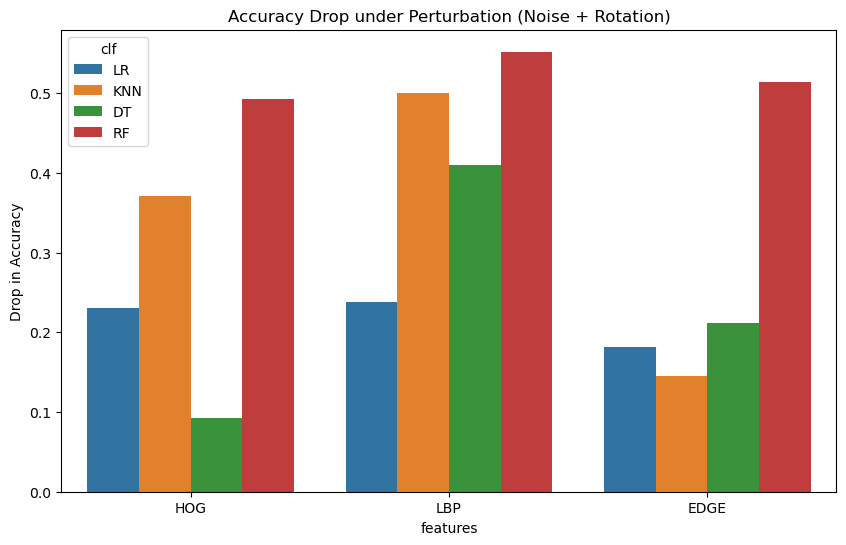

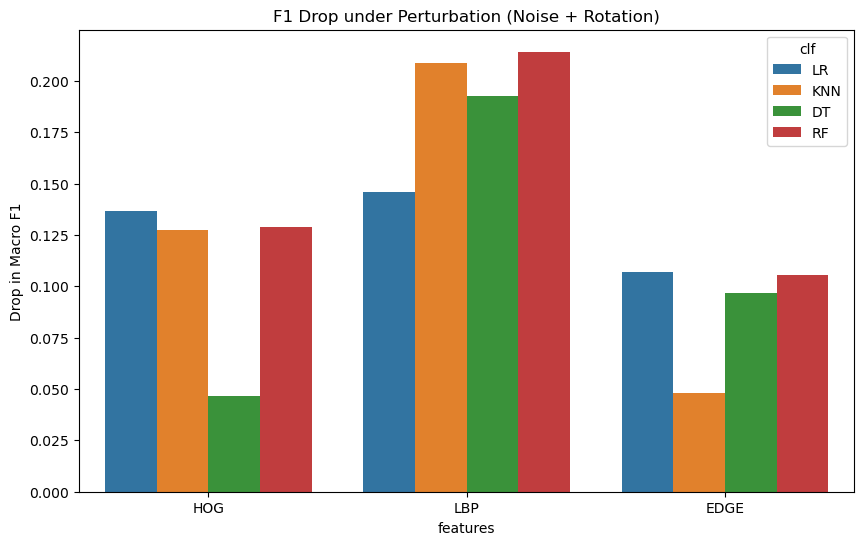

In [32]:
plt.figure(figsize=(10,6))
sns.barplot(data=robust_df, x="features", y="drop_acc", hue="clf")
plt.title("Accuracy Drop under Perturbation (Noise + Rotation)")
plt.ylabel("Drop in Accuracy")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=robust_df, x="features", y="drop_f1", hue="clf")
plt.title("F1 Drop under Perturbation (Noise + Rotation)")
plt.ylabel("Drop in Macro F1")
plt.show()
